# DBSCAN Clustering

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
%matplotlib inline
plt.style.use('seaborn')

In [2]:
import numpy as np
import sklearn
import matplotlib
import pandas as pd
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.12.1
Pandas Version: 0.20.3


In [298]:
import numpy as np
import pandas as pd
from copy import copy

class dbscan:
    
    def __init__(self, epsilon=0.5, min_points=5):
        """
        DBSCAN is a clustering algorithm that uses a "neighborhood"
        approach to building clusters. It also allows for points to 
        be marked as 'noise' points that do not belong to any
        cluster. The basis of the algorithm are core points 
        (points that have at least min_points neighbors within a 
        circle of radius epsilon) claiming all of their neighbors 
        as part of their own cluster. Points that belong to a core point 
        are called "reachable points" if they are not also core 
        (don't also have min_points neighbors). Any point not reachable
        by any core points are marked as outliers.
        ---
        KWargs:
        epsilon: how large is the neighborhood circle to check for
        neighbors.
        min_points: how many neighbors are required to become a core
        point (neighbor counts includes self)
        """
        self.epsilon = epsilon
        self.min_points = min_points
        self.data_cols = None
        self.labels_ = None
        self.neighbors = {}
        self.core_points = []
        
    def fit(self, X):
        """
        Computes who the neighbors are for every point,
        and compiles a list of core points. Then visits
        every core points and labels all of its neighbors
        as part of its cluster. If the core point we're
        visiting already has a non-noise label, we keep
        that label when adding points to the cluster. 
        Otherwise, we start a new cluster by adding a new
        cluster_id. At the end, since the clusters will fight
        over shared border points and overlap each other,
        we are unlikely to have cluster labels that are
        [0,1,2,3,...] and instead may have [6,9,11,22,...]
        so we relabel the clusters using a separate method.
        """
        X = self.convert_to_array(X)
        
        self.labels_ = [-1]*X.shape[0]
        
        for id1, pt in enumerate(X):
            neighbors = self.get_neighbors(id1, X)
            self.neighbors[id1] = neighbors
            if len(neighbors) >= self.min_points:
                self.core_points.append(id1)
        self.core_points_ = copy(self.core_points)
        
        num_clusters = 0
        while len(self.core_points) > 0:
            core_point_id = np.random.choice(self.core_points)
            self.core_points.remove(core_point_id)
            
            cluster_id = self.labels_[core_point_id]
            if cluster_id == -1:
                cluster_id = num_clusters
                num_clusters += 1
            
            for neighbor in self.neighbors[core_point_id]:
                self.labels_[neighbor] = cluster_id
          
        self.labels_ = np.array(self.labels_)
        self.relabel_correctly()
        
        
    def relabel_correctly(self):
        """
        Iterates through all of the labels after the clustering
        is completed and reassigns them to smaller, sequential
        numberings. Doesn't do so for -1, so it remains as a 
        special marker for noise points.
        """
        current_labels = set(self.labels_)
        new_label = 0
        for current_label in current_labels:
            if current_label != -1:
                self.labels_[self.labels_ == current_label] = new_label
                new_label += 1
    
    def fit_predict(self,X):
        """
        Builds the clusters for a given dataset and returns
        the labels for each point.
        """
        self.fit(X)
        return self.labels_
    
    def get_neighbors(self, ix, X):
        """
        Measures the distance between the initial point
        (ix) and all other points. If those points are
        withing a distance of epsilon from the initial point
        they are considered neighbors.
        ---
        Input: 
        ix: ID of the original core point,
        X: array of all data
        
        Output:
        neighbors: list of ids for all neighbor points
        """
        neighbors = []
        pt = X[ix]
        for ix2, pt2 in enumerate(X):
            dist = np.sqrt(np.sum((pt2 - pt)**2)) 
            if dist <= self.epsilon:
                neighbors.append(ix2)
        return neighbors
        
    def rbf_kernel(self, x1, x2, sig=1.):
        """
        Returns the rbf affinity between two points (x1 and x2),
        for a given bandwidth (standard deviation).
        ---
        Inputs: 
            x1; point 1(array)
            x2; point 2(array)
            sig; standard deviation (float)
        """
        diff = np.sum((x1-x2)**2)
        norm = 1/(np.sqrt(2*np.pi*sig**2))
        return norm*np.exp(-diff/(2*sig**2))
    
    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.as_matrix()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x) 
    
    def handle_1d_data(self,x):
        """
        Converts 1 dimensional data into a series of rows with 1 columns
        instead of 1 row with many columns.
        """
        if x.ndim == 1:
            x = x.reshape(-1,1)
        return x
    
    def convert_to_array(self, x):
        """
        Takes in an input and converts it to a numpy array
        and then checks if it needs to be reshaped for us
        to use it properly
        """
        x = self.pandas_to_numpy(x)
        x = self.handle_1d_data(x)
        return x

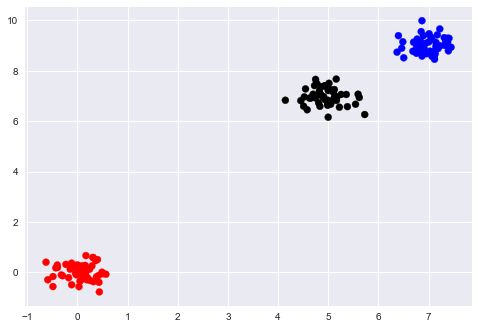

In [299]:
np.random.seed(24)
def get_data(n_clust = 3, n_points=50):
    X1 = np.random.normal(0,.3,n_points).reshape(-1,1)
    y1 = np.random.normal(0,.3,n_points).reshape(-1,1)
    for _ in range(n_clust-1):
        X2 = np.random.normal(np.random.randint(0,10),.3,n_points).reshape(-1,1)
        y2 = np.random.normal(np.random.randint(0,10),.3,n_points).reshape(-1,1)
        X1 = np.vstack((X1,X2)).reshape(-1,1)
        y1 = np.vstack((y1,y2)).reshape(-1,1)
    X = np.hstack((X1,y1))
    return X

X = get_data(n_clust=3, n_points=50)
c = ['r']*50+['b']*50+['k']*50
plt.scatter(X[:,0],X[:,1], c=c);

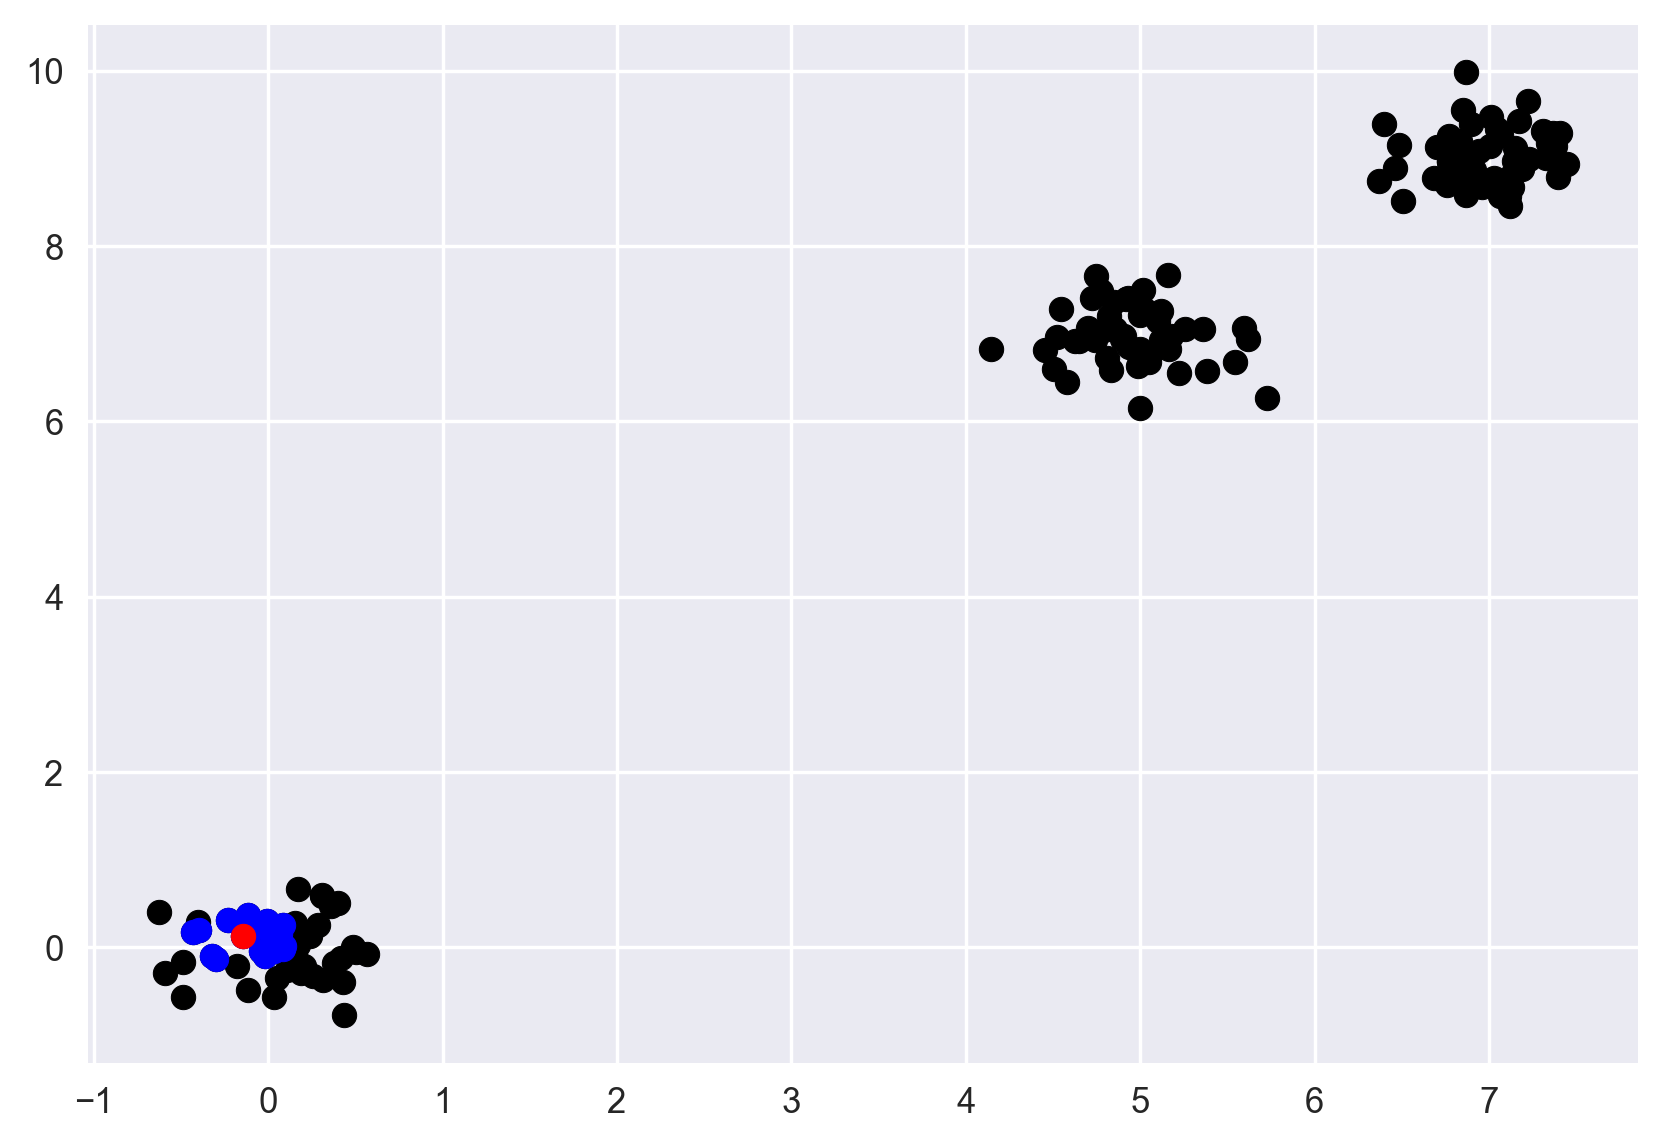

In [300]:
db = dbscan(epsilon=.3)
neighbs = db.get_neighbors(14, X)

plt.figure(dpi=250)
plt.scatter(X[:,0],X[:,1], c='k')
for ix in neighbs:
    plt.scatter(X[ix,0], X[ix,1], c='b')
plt.scatter(X[14,0], X[14,1], c='r');

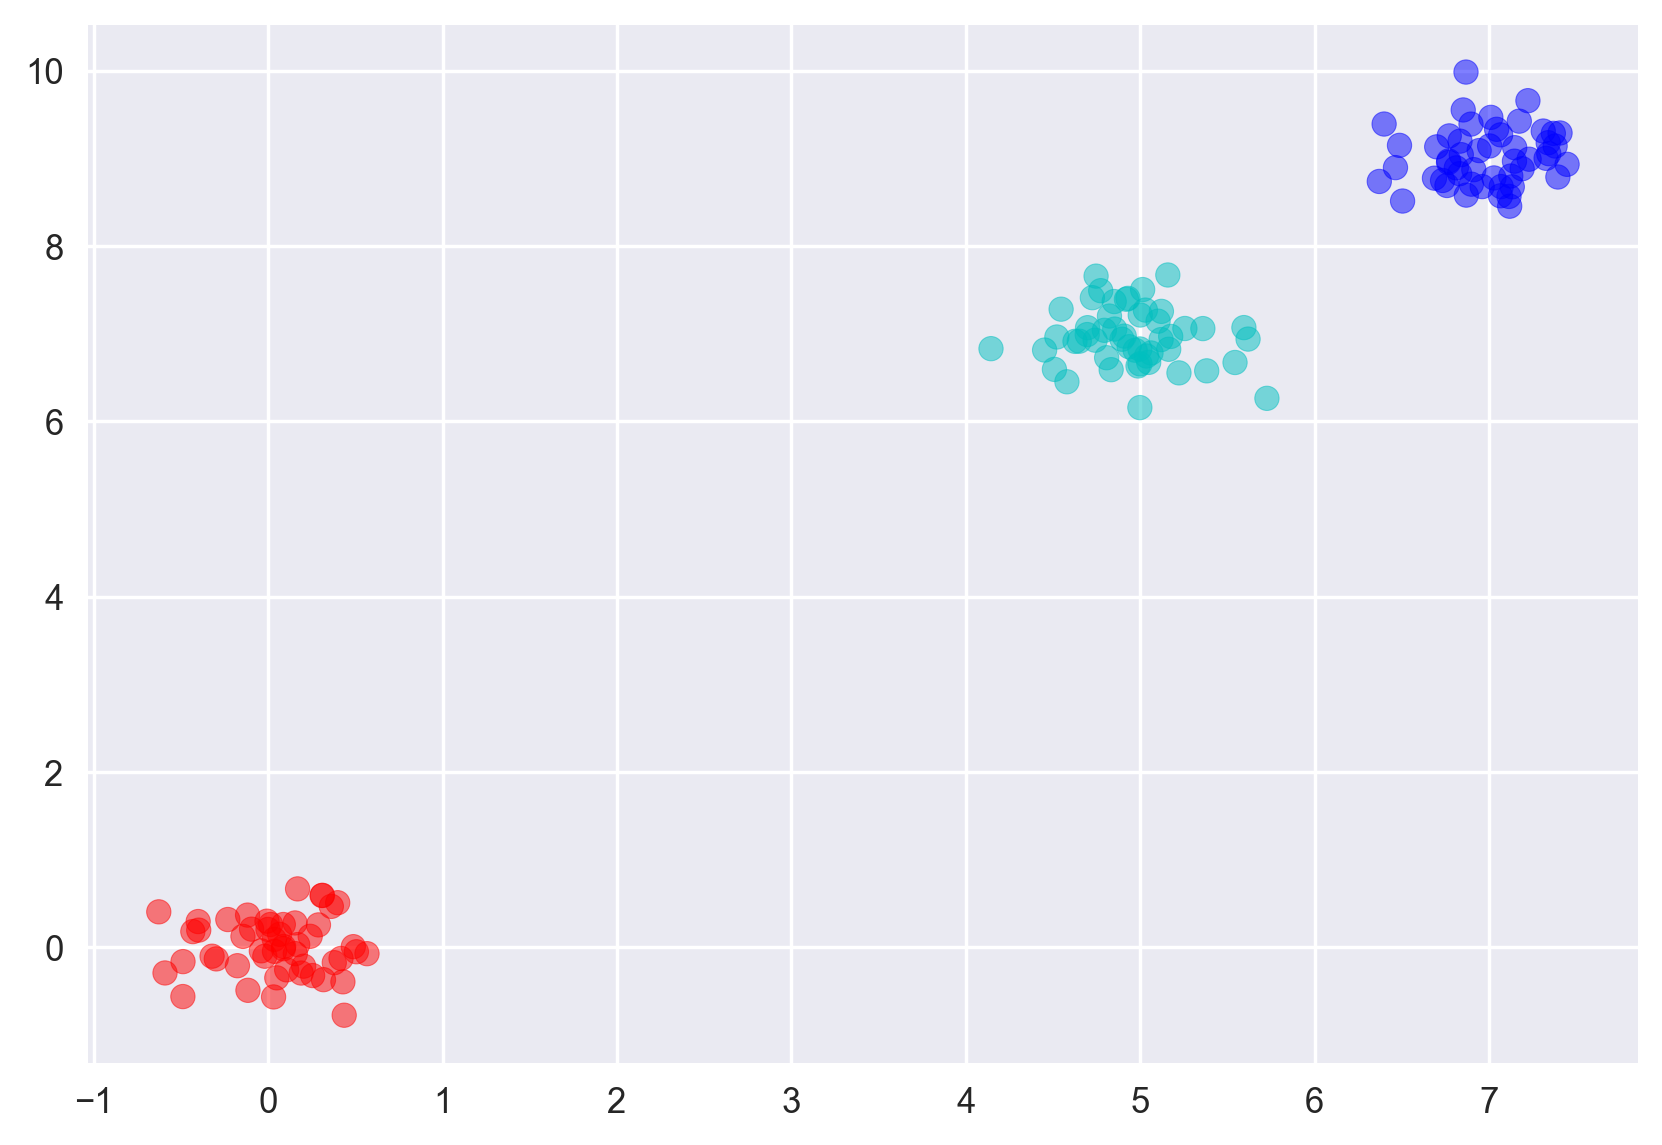

In [301]:
db = dbscan(epsilon=1.3, min_points=10)
db.fit(X)

color_possibilities = 'rbcmyg'
colors = []
for i in db.labels_:
    if i == -1:
        colors.append('k')
    else:
        colors.append(color_possibilities[i%len(color_possibilities)])
        
plt.figure(dpi=250)
plt.scatter(X[:,0],X[:,1], c=colors, alpha=0.5);

## Test with circular data to make sure it works on non-blobs

In [305]:
from sklearn.datasets import make_circles

circle_X = make_circles(n_samples=2000, shuffle=True, noise=0.02, random_state=42, factor = 0.5)
db_circ = dbscan(epsilon=0.35, min_points=2)
db_circ.fit(circle_X[0])

In [306]:
np.unique(db_circ.labels_)

array([0, 1])

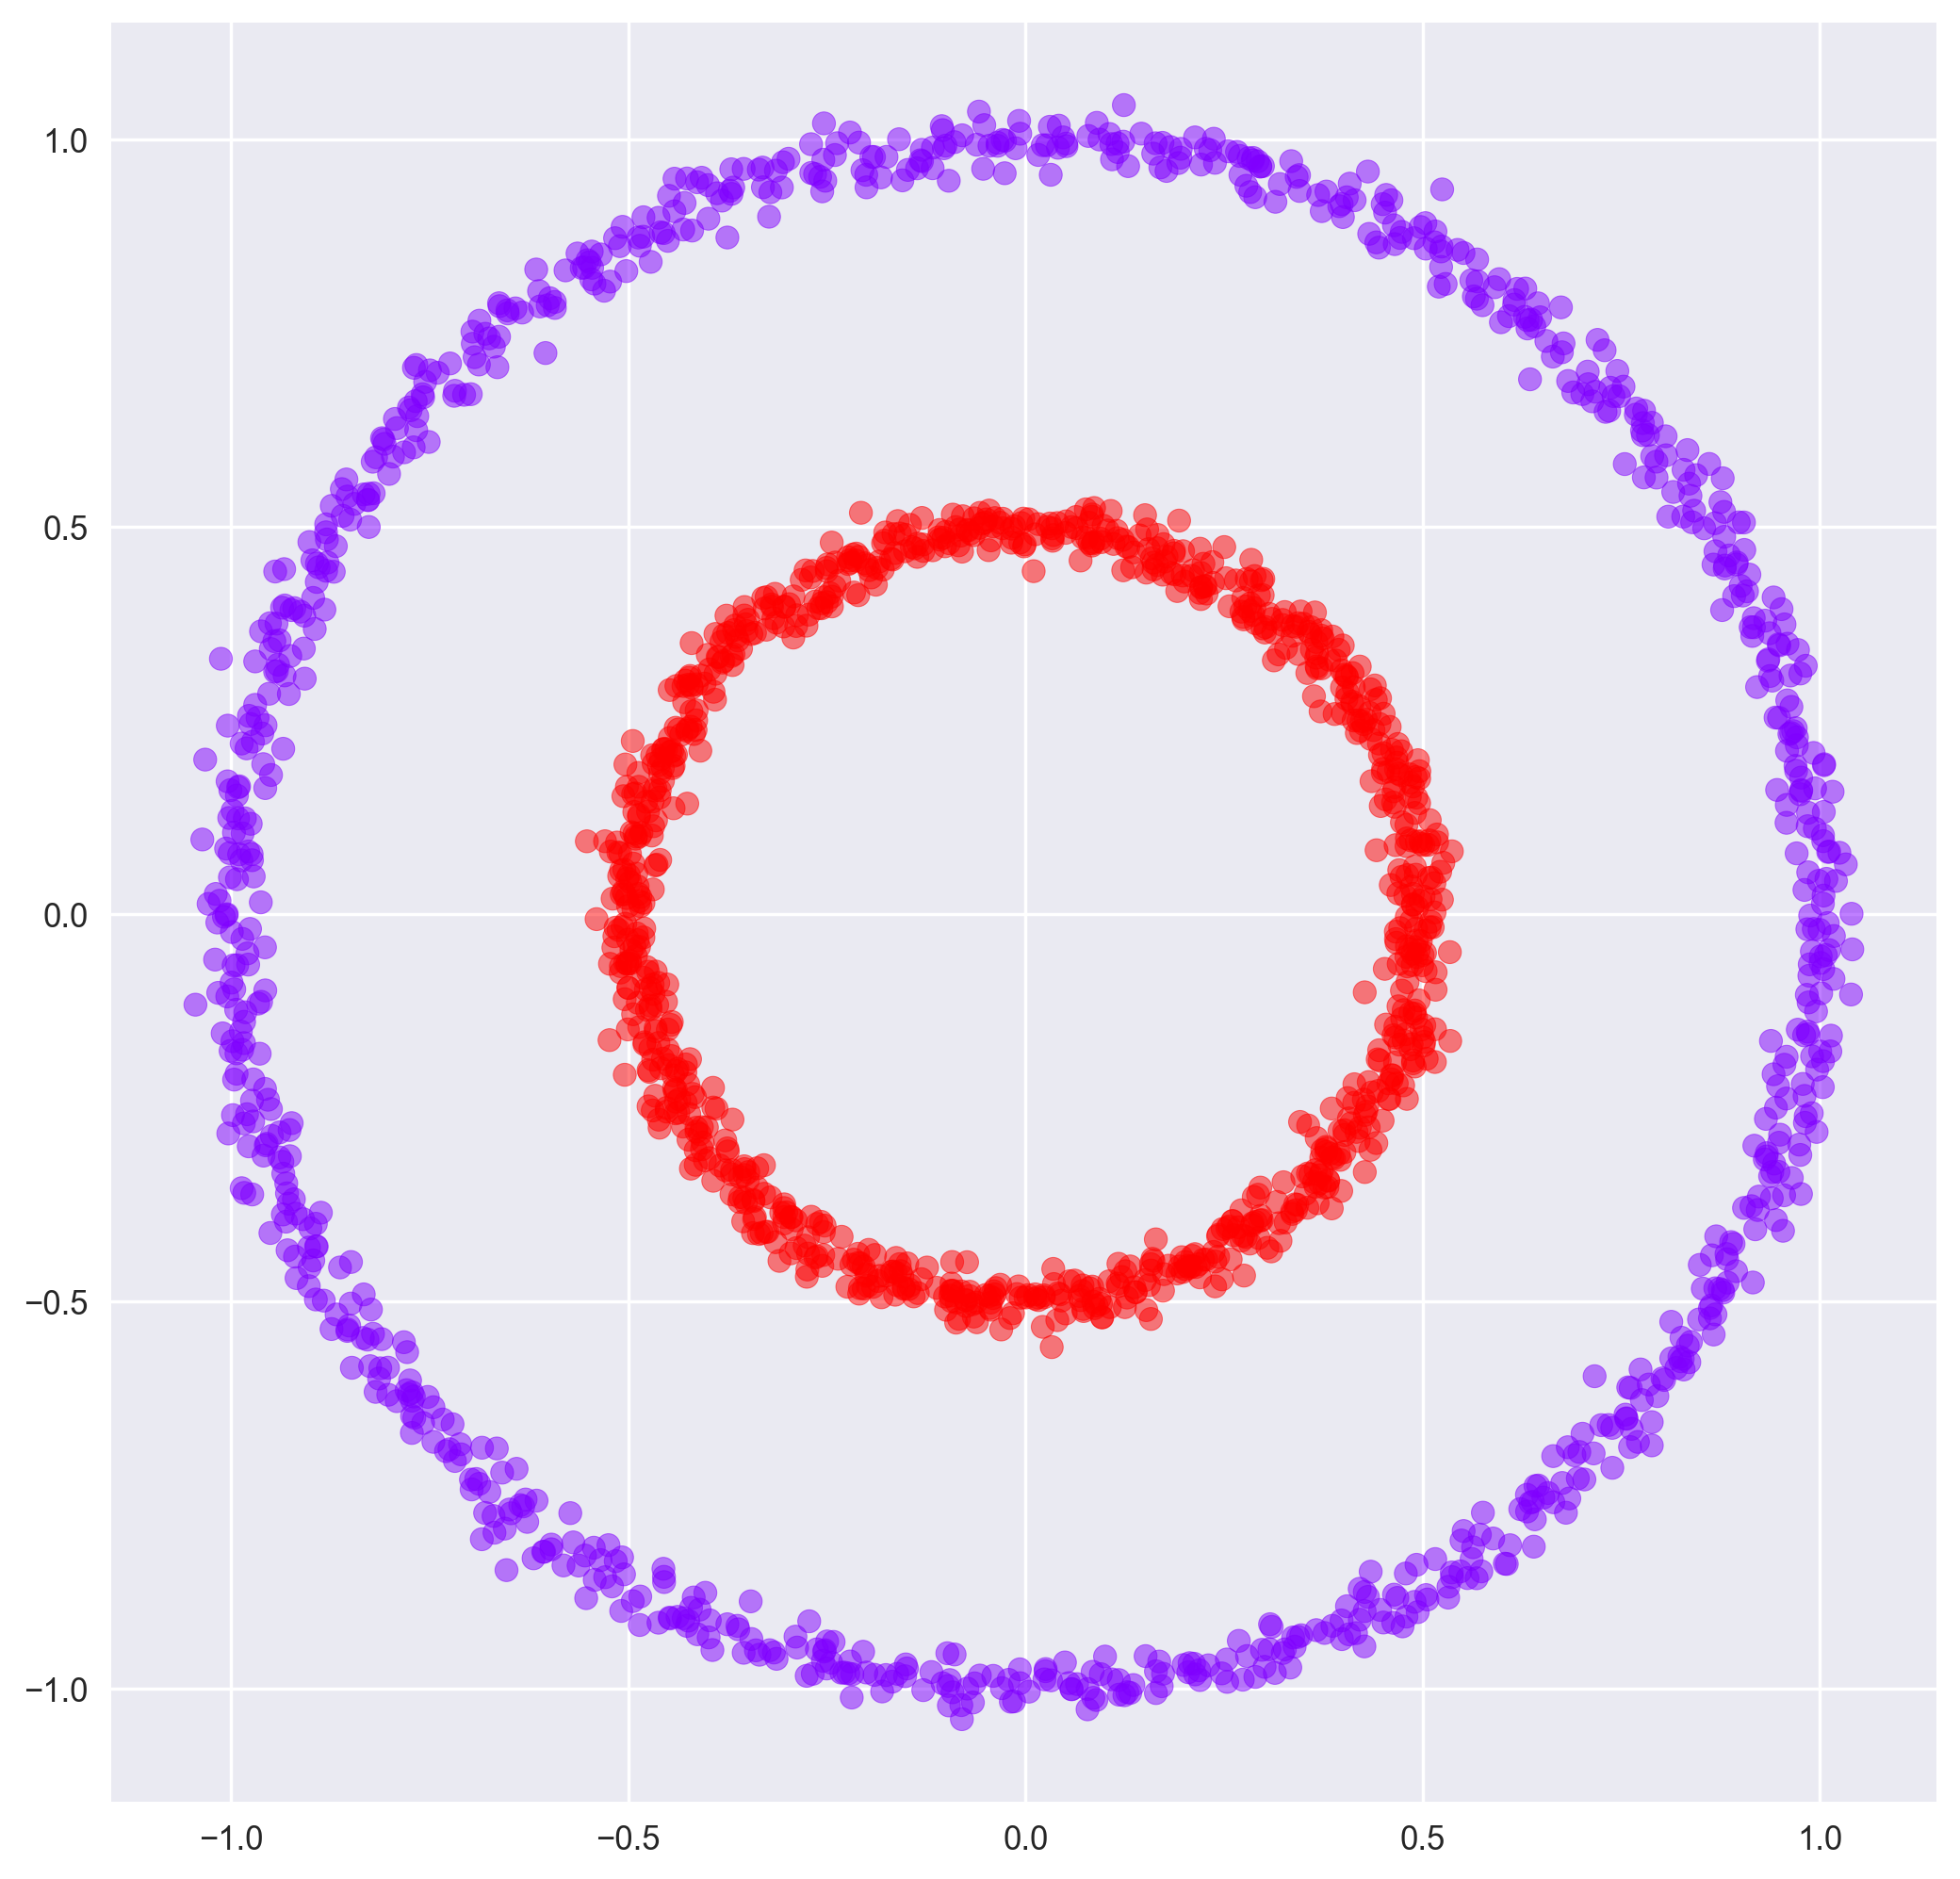

In [307]:
plt.figure(figsize=(10,10), dpi=250)
circle_x, circle_y = zip(*circle_X[0])
plt.scatter(circle_x, circle_y, c=plt.cm.rainbow(db_circ.labels_/np.max(db_circ.labels_)), alpha=0.5);

# Test in 3D

In [308]:
np.random.seed(42)
def get_multidim_data(n_clust = 3, num_dim=3):
    X = np.random.normal(-5,1,size=(50,3))

    for _ in range(n_clust-1):
        X2 = np.random.normal(np.random.randint(-10,10),1,size=(50,3))
        X = np.vstack((X,X2))
    return X

X = get_multidim_data(n_clust=5)

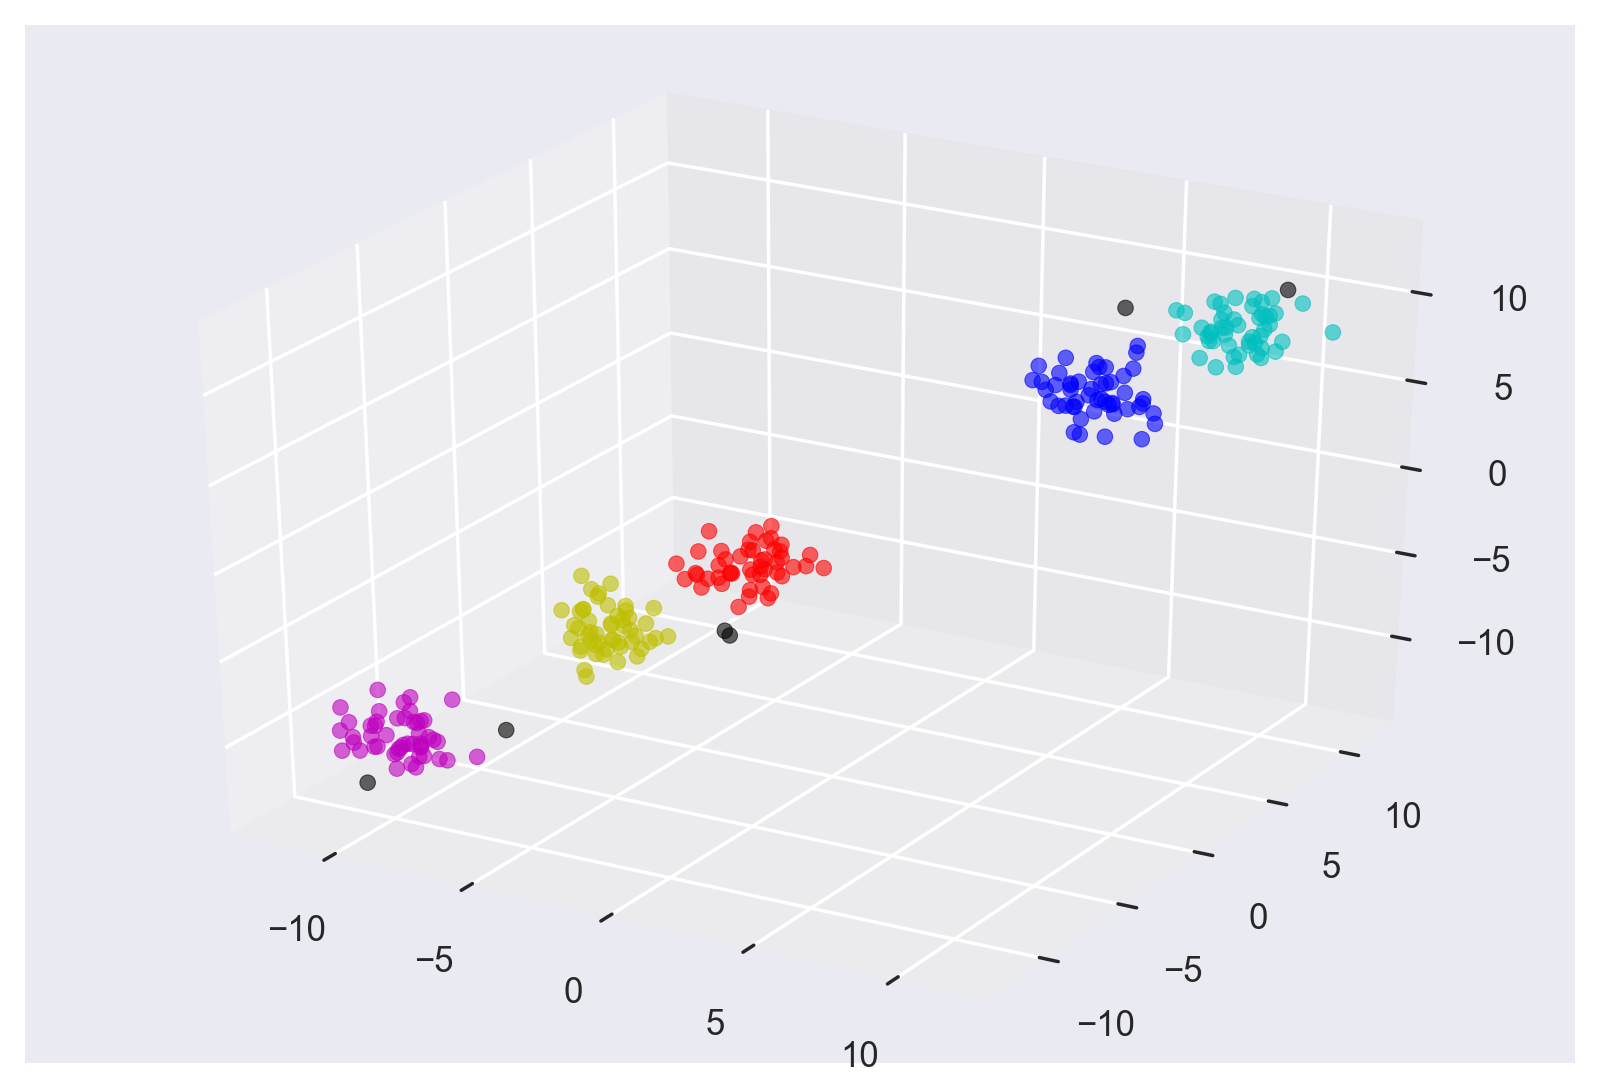

In [314]:
db = dbscan(epsilon=1.9, min_points=8)
preds = db.fit_predict(X)

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(dpi=250)
ax = fig.gca(projection='3d')

color_possibilities = 'rbcmyg'
colors = []
for i in db.labels_:
    if i == -1:
        colors.append('k')
    else:
        colors.append(color_possibilities[i%len(color_possibilities)])

xplot, yplot, zplot = zip(*X)
ax.scatter(xplot,yplot, zplot, c=colors,alpha=0.6);


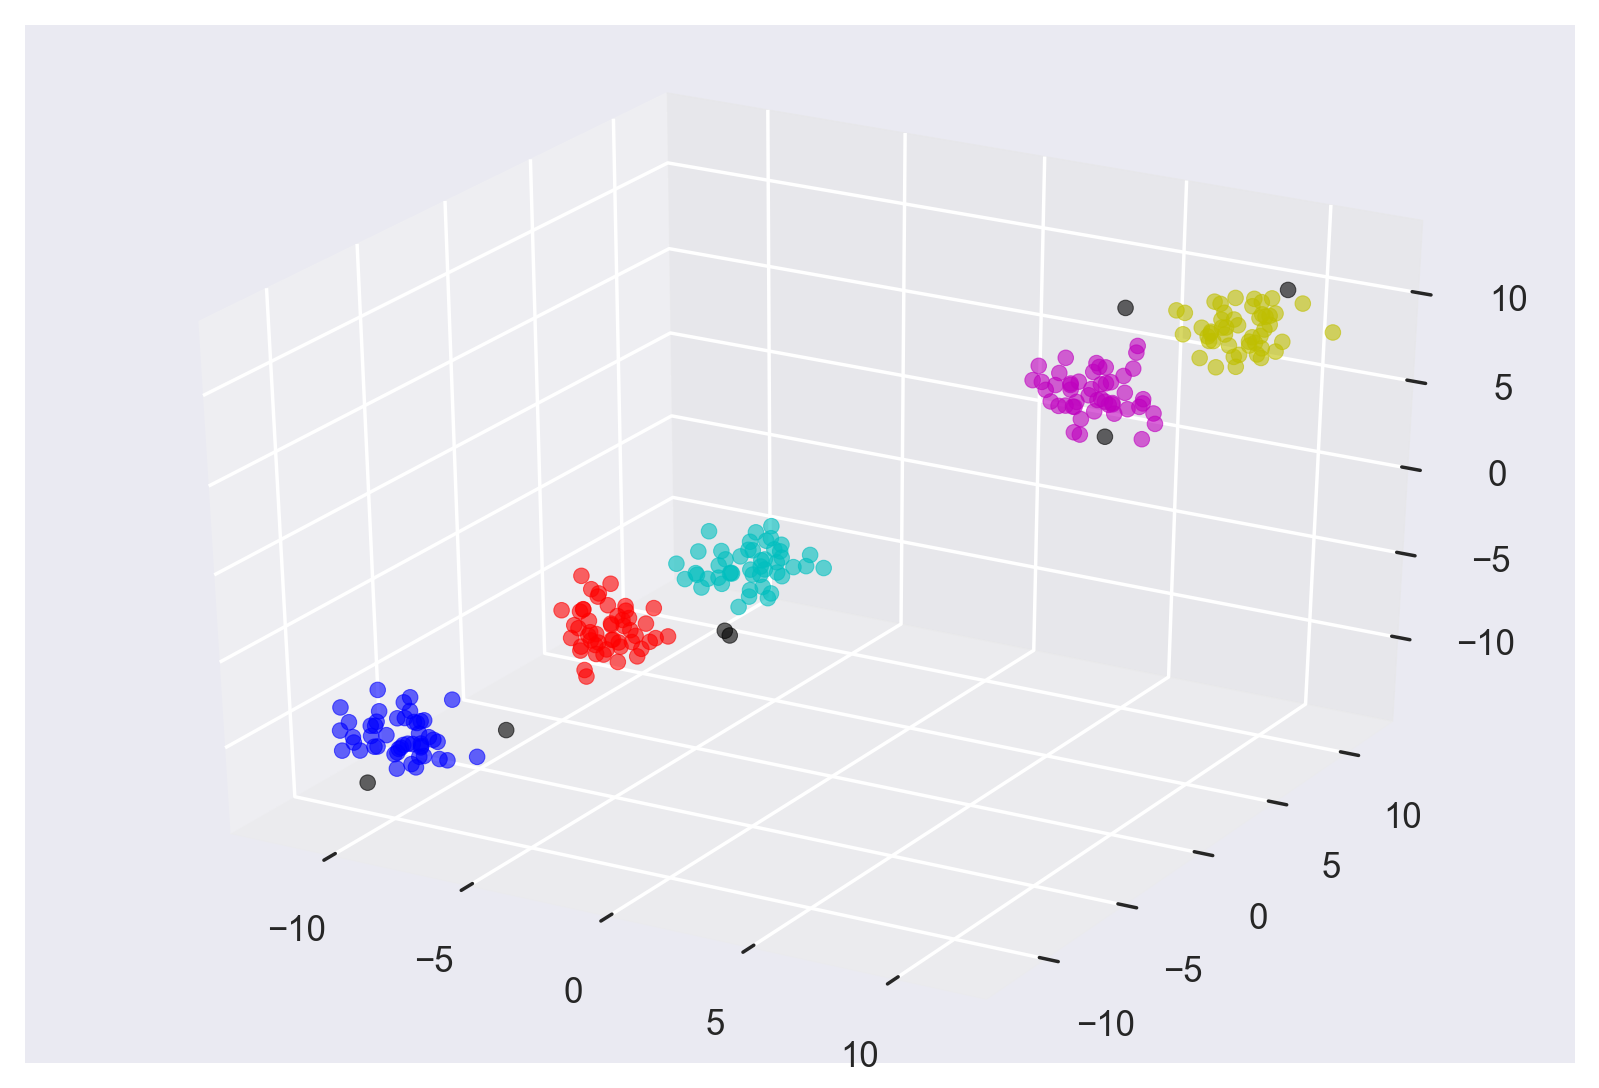

In [311]:
from sklearn.cluster import DBSCAN

db_sk = DBSCAN(eps=1.8, min_samples=8)
db_sk.fit(X)

fig = plt.figure(dpi=250)
ax = fig.gca(projection='3d')

color_possibilities = 'rbcmyg'
colors = []
for i in db_sk.labels_:
    if i == -1:
        colors.append('k')
    else:
        colors.append(color_possibilities[i%len(color_possibilities)])
        
xplot, yplot, zplot = zip(*X)
ax.scatter(xplot,yplot, zplot, c=colors,alpha=0.6);